## Delivery Duration Prediction

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from:

__Start:__ the time consumer submits the order `(created_at)` to
<br>
__End:__ when the order will be delivered to the consumer `(actual_delivery_time)`

#### My Approach

The dataset comes with two other predicted values: `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration`. The missing piece is the amount of time the order spends in the store. In addition to generic feature engineering, I will be creating separate order 'prep_time' statistics tables/dataframes to simulate gold fact tables in a database or features from a feature store (i.e. Feather, Feast) that would in turn live in a data lake.

This is a fairly popular exercise so it is possible to derive performance objectives. My goal is to produce a feature set and model that has a test RMSE of less than 1200 seconds and a test MAE of less than 600 seconds, with a stretch goal of 600 seconds for the test RMSE. For reference, the best models publically available produce a test RMSE around 980 - 1000 seconds with a holdout size of 0.2. 

In [1]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from flaml import AutoML
from flaml.automl.model import XGBoostEstimator

In [2]:
np.random.seed(42)

In [3]:
## update types
## create target variable
def addFeatures_durations(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
        historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])
        ## calculate delivery duration
        historical_data['actual_total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()
        ## estimated time spent outside the store/not on order preparation
        historical_data['est_time_non-prep'] = historical_data['estimated_order_place_duration'] + historical_data['estimated_store_to_consumer_driving_duration']
    except Exception as ex:
        raise ex
    return historical_data

In [4]:
def createBaseline(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
    historical_data = addFeatures_durations(historical_data=historical_data)
    try:
        baseline_data = historical_data[['store_id','actual_total_delivery_duration']]
        baseline_data = baseline_data.dropna()
        baseline_data = pd.merge(
            left=baseline_data,
            right=baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean,np.std]),
            how='inner',
            on='store_id'
        )
        baseline_data['z-score'] = (baseline_data['actual_total_delivery_duration'] - baseline_data['mean']) / baseline_data['std']
        baseline_data = baseline_data.loc[(baseline_data['z-score'] <=3) & (baseline_data['z-score'] >= -3)]
        baseline_avgs = baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean])
        baseline_data = pd.merge(
            left=historical_data[['store_id','actual_total_delivery_duration']].dropna(),
            right=baseline_avgs,
            on='store_id'
        )
        baseline_MAE = mean_absolute_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'])
        baseline_RMSE = mean_squared_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'],squared=False)
    except Exception as ex:
        raise ex
    return {'baseline_MAE:':baseline_MAE,'baseline_RMSE:':baseline_RMSE}

In [5]:
## TODO #4 create estimated prep time features that are anchored to stores and/or categories -- DONE
# the est_time_prep feature depends on the actual delivery datetime, which can't be provided to a model
# BUT a set of values derived from historical data can be given to a model on demand

def addFeatures_store_prep_stats(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
## returns a separate dataframe with the min, max, median and mean and standard deviation of the est_prep_time_per_item for each store_id
    try:
        historical_data = addFeatures_durations(historical_data=historical_data)
        ## calculate the amount of time (in seconds) the order spends in the store, then divide by the total number of items in the order
        historical_data['est_time_prep_per_item'] = (historical_data['actual_total_delivery_duration'] - historical_data['est_time_non-prep']) / historical_data['total_items']
        historical_data = historical_data[historical_data['est_time_prep_per_item'] > 0]
        store_prep_stats_df = historical_data[['store_id','est_time_prep_per_item']].groupby('store_id').est_time_prep_per_item.aggregate([np.mean,np.std])
        ## calculate z-score
        store_prep_facts_df = pd.merge(
            left=store_prep_stats_df.reset_index(),
            right=historical_data[['store_id','est_time_prep_per_item']],
            how='inner',
            on='store_id'
        )
        store_prep_facts_df['z_score'] = (store_prep_facts_df['est_time_prep_per_item'] - store_prep_facts_df['mean']) / store_prep_facts_df['std']
        ## drop outliers
        store_prep_stats_df = store_prep_facts_df.loc[(store_prep_facts_df['z_score'] <=3) & (store_prep_facts_df['z_score'] >= -3)]
        store_prep_stats_df = store_prep_stats_df.drop(columns=['mean','std'])
        store_prep_stats_df = store_prep_stats_df.groupby('store_id').est_time_prep_per_item.aggregate(['min','max','median',np.mean,np.std])
        store_prep_stats_df = store_prep_stats_df.add_prefix('store_est_time_prep_per_item_')
    except Exception as ex:
        raise ex
    return store_prep_stats_df

def addFeatures_category_prep_stats(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
## returns a separate dataframe with the min,max, median, mean and standard deviation for each category
    try:
        historical_data = addFeatures_durations(historical_data=historical_data)
        ## calculate the amount of time (in seconds) the order spends in the store, then divide by the total number of items in the order
        historical_data['est_time_prep_per_item'] = (historical_data['actual_total_delivery_duration'] - historical_data['est_time_non-prep']) / historical_data['total_items']
        historical_data = historical_data[historical_data['est_time_prep_per_item'] > 0]
        category_prep_stats_df = historical_data[['clean_store_primary_category','est_time_prep_per_item']].groupby('clean_store_primary_category').est_time_prep_per_item.aggregate([np.mean,np.std])
        ## calculate z-score
        category_prep_facts_df = pd.merge(
            left=category_prep_stats_df.reset_index(),
            right=historical_data[['created_at','clean_store_primary_category','est_time_prep_per_item']],
            how='inner',
            on='clean_store_primary_category'
        )
        category_prep_facts_df['z_score'] = (category_prep_facts_df['est_time_prep_per_item'] - category_prep_facts_df['mean']) / category_prep_facts_df['std']
        ## drop outliers
        category_prep_stats_df = category_prep_facts_df.loc[(category_prep_facts_df['z_score'] <= 3) & (category_prep_facts_df['z_score'] >= -3)]
        category_prep_stats_df = category_prep_stats_df.drop(columns=['mean','std','created_at'])
        category_prep_stats_df = category_prep_stats_df.groupby('clean_store_primary_category').est_time_prep_per_item.aggregate(['min','max','median',np.mean,np.std])
        category_prep_stats_df = category_prep_stats_df.add_prefix('category_est_time_prep_per_item_')
    except Exception as ex:
        raise ex
    return category_prep_stats_df

In [6]:
## add time of day features

def addFeatures_time_of_day(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['created_hour_of_day'] = historical_data['created_at'].dt.hour
        historical_data['created_day_of_week'] = historical_data['created_at'].dt.day_of_week
    except Exception as ex:
        raise ex
    return historical_data

In [7]:
## add ratio features
def addFeatures_ratios(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['available_dashers'] = historical_data['total_onshift_dashers'] - historical_data['total_busy_dashers']
        historical_data['busy_to_onshift'] = historical_data['total_onshift_dashers'] / historical_data['total_busy_dashers']
        historical_data['busy_to_onshift'].replace(to_replace=[np.inf,-np.inf],value=historical_data['total_onshift_dashers'][1],inplace=True)
        historical_data['busy_to_outstanding'] = historical_data['total_busy_dashers'] / historical_data['total_outstanding_orders']
        historical_data['busy_to_outstanding'].replace(to_replace=[np.inf,-np.inf,np.nan],value=0,inplace=True)
        historical_data['onshift_to_outstanding'] = historical_data['total_onshift_dashers'] / historical_data['total_outstanding_orders']
        historical_data['onshift_to_outstanding'].replace([np.inf,-np.inf],0,inplace=True)
    except Exception as ex:
        raise ex
    return historical_data

In [8]:
## add dummies for categories
def addFeatures_dummies(historical_data:pd.DataFrame,dummy_column:str) -> pd.DataFrame:
    try:
        dumm = pd.get_dummies(historical_data[dummy_column],prefix=str(dummy_column + '_'),dtype=float)
        # concat dummies
        historical_data = pd.concat([historical_data,dumm],axis=1)
        historical_data = historical_data.drop(columns=[dummy_column])
    except Exception as ex:
        raise ex
    return historical_data

In [37]:
## remove confounding outliers
def cleanFeatures_remove_outliers(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data = historical_data.loc[historical_data['actual_total_delivery_duration'] > historical_data['est_time_non-prep']]
        historical_data = historical_data[historical_data['actual_total_delivery_duration'] <= 7200]
    except Exception as ex:
        raise ex
    return historical_data        

In [38]:
historical_data = pd.read_csv('historical_data.csv')


store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
# fill null values
historical_data["clean_store_primary_category"] = historical_data.store_id.apply(fill)

## build store, category prep time statistics DataFrames
store_prep_stats_df = addFeatures_store_prep_stats(historical_data=historical_data)
category_prep_stats_df = addFeatures_category_prep_stats(historical_data=historical_data)
## build the training dataset using the functions above
train_df = addFeatures_durations(historical_data=historical_data)
train_df = addFeatures_ratios(historical_data=train_df)
train_df = addFeatures_time_of_day(historical_data=train_df)
## merge store, category prep stats DataFrames with train_df
train_df = pd.merge(
    left=train_df,
    right=store_prep_stats_df.reset_index(),
    how='inner',
    on='store_id'
)
train_df = pd.merge(
    left=train_df,
    right=category_prep_stats_df.reset_index(),
    how='inner',
    on='clean_store_primary_category'
)
## remove confounding outliers
train_df = cleanFeatures_remove_outliers(historical_data=train_df)
## add total prep time estimations
train_df['store_est_median_total_prep_time'] = train_df['total_items'] * train_df['store_est_time_prep_per_item_median']
train_df['store_est_mean_total_prep_time'] = train_df['total_items'] * train_df['store_est_time_prep_per_item_mean']
## add dummy columns for clean_store_primary_category, market_id, order_protocol
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='clean_store_primary_category')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='market_id')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='order_protocol')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='created_hour_of_day')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='created_day_of_week')
## prep time training dataframe
prep_time_df = train_df.copy(deep=True)
prep_time_df['est_order_total_prep_time'] = prep_time_df['actual_total_delivery_duration'] - prep_time_df['est_time_non-prep']
#prep_time_df['est_order_time_prep_per_item'] = prep_time_df['est_order_total_prep_time'] / prep_time_df['total_items']
## drop the native 'store_primary_category' column and all remaining non-feature columns, then do a headcheck
train_df.drop(columns=['store_primary_category','created_at','actual_delivery_time','store_id','est_time_prep_per_item'],inplace=True)
prep_time_df.drop(columns=['store_primary_category','created_at','actual_delivery_time','store_id','est_time_prep_per_item','actual_total_delivery_duration'],inplace=True)
## drop NaN's
train_df.dropna(inplace=True)
train_df = train_df.astype("float32")
prep_time_df.dropna(inplace=True)
prep_time_df = prep_time_df.astype('float32')

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,created_hour_of_day__21,created_hour_of_day__22,created_hour_of_day__23,created_day_of_week__0,created_day_of_week__1,created_day_of_week__2,created_day_of_week__3,created_day_of_week__4,created_day_of_week__5,created_day_of_week__6
0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,5000.0,3.0,1500.0,1900.0,2.0,2.0,2.0,446.0,338.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
prep_time_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,created_hour_of_day__22,created_hour_of_day__23,created_day_of_week__0,created_day_of_week__1,created_day_of_week__2,created_day_of_week__3,created_day_of_week__4,created_day_of_week__5,created_day_of_week__6,est_order_total_prep_time
0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2888.0
1,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,645.0
2,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2340.0
3,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1294.0
4,3.0,5000.0,3.0,1500.0,1900.0,2.0,2.0,2.0,446.0,338.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1516.0


In [10]:
## dimensionality reduction functions with variance inflaction

def calcVIF(feature_frame:pd.DataFrame,target_feature:str):
    try:
        feature_frame = add_constant(feature_frame)
        feature_list = feature_frame.drop(columns=[target_feature]).columns.to_list()
        vif_frame = pd.DataFrame()
        vif_frame['feature'] = feature_list
        vif_frame['VIF'] = [variance_inflation_factor(feature_frame[feature_list].values,i) for i in range(len(feature_list))]
    except Exception as ex:
        raise ex
    return vif_frame.sort_values(by=['VIF'],ascending=False).reset_index(drop=True)

def VIF_dim_reduction(feature_frame:pd.DataFrame,target_feature:str,vif_limit:int):
    vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
    try:
        ## drop nan columns from feature set, nan VIF values from base VIF table
        vif_table['VIF'].replace(to_replace=[np.inf,-np.inf],value=np.nan,inplace=True)
        nan_list = vif_table[vif_table['VIF'].isnull()]['feature'].to_list()
        feature_frame = feature_frame.drop(columns=nan_list)
        vif_table = vif_table.set_index(vif_table.feature)
        vif_table = vif_table.drop(labels=nan_list).reset_index(drop=True)
        ## start
        multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
        while multicollinearity:
            lead_vif_feature = vif_table['feature'].values.tolist()[1]
            feature_frame = feature_frame.drop(columns=lead_vif_feature)
            vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
            multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
    except Exception as ex:
        raise ex
    return feature_frame,vif_table

In [11]:
## feature selection/dimensionality reduction with PCA
##TODO #2 make a class for PCA
##TODO #3 retain row numbers in scaler --DONE

def build_train_test(dataset:pd.DataFrame,target_feature:str,test_size:int):
    try:
        X = dataset.drop(columns=target_feature)
        y = dataset[target_feature]
        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42)
        x_train,x_test = pd.DataFrame(x_train),pd.DataFrame(x_test)
    except Exception as ex:
        raise ex
    return x_train,x_test,y_train,y_test

def apply_standard_scaler(dataset):
#applies the standard scaler to a single dataset
    scaler = StandardScaler()
    try:
        if type(dataset) == pd.DataFrame:
            scaler = scaler.fit(dataset.values)
            dataset_scaled = scaler.transform(dataset.values)
            dataset_scaled = pd.DataFrame(dataset_scaled,index=dataset.index,columns=dataset.columns)
        else:
            scaler = scaler.fit(dataset)
            dataset_scaled = scaler.transform(dataset)
            test_stdScale = scaler.transform(dataset)
    except Exception as ex:
        raise ex
    return dataset_scaled,scaler

def transform_rmse_to_seconds(scaler,y_test,y_hat_scaled):
    try:
        y_hat_descaled = scaler.inverse_transform(y_hat_scaled.reshape(-1,1))
        rmse_descaled = mean_squared_error(y_pred=y_test,y_true=y_hat_descaled[:,0],squared=False)
    except Exception as ex:
        raise ex
    return y_hat_descaled,rmse_descaled

In [12]:
def PCAcalc_expl_var(x_train,target_expl_variance:int):
## returns the number of components required to explain the target_expl_variance
# and a feature to component ratio to support automation of further dimensionality reduction
    pca = PCA()
    x_train_scaled = apply_standard_scaler(x_train)[0]
    try:
        pca = pca.fit(x_train_scaled)
        components = np.cumsum(pca.explained_variance_ratio_)
        components = [i for i in components if i <= target_expl_variance]
        feature_to_component_ratio = len(components)/x_train.shape[1]
    except Exception as ex:
        raise ex
    return components,feature_to_component_ratio

def PCAcalc_dim_reduction(x_train,x_test,desired_components:int):
## you know, dimensionality reduction
    pca = PCA(n_components=desired_components)
    x_train_scaled,x_test_scaled = apply_standard_scaler(x_train)[0],apply_standard_scaler(x_test)[0]
    try:
        pca = pca.fit(x_train_scaled)
        x_train_pca,x_test_pca = pca.transform(x_train_scaled),pca.transform(x_test_scaled)
    except Exception as ex:
        raise ex
    return x_train_pca,x_test_pca

#### Dimensionality reduction with VIF

In [ ]:
VIF_features = VIF_dim_reduction(feature_frame=train_df,target_feature='actual_total_delivery_duration',vif_limit=20)[1]
VIF_featureset = VIF_features.drop(VIF_features[VIF_features.feature == 'const'].index)
VIF_featureset = VIF_featureset['feature'].to_list()
VIF_featureset = VIF_featureset + ['actual_total_delivery_duration']
VIF_train_df = train_df[VIF_featureset]

In [17]:
vif_x_train,vif_x_test,vif_y_train,vif_y_test = build_train_test(dataset=VIF_train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

We need 15 features (out of 25 available) to explain 90 percent of the variance after VIF dimensionality reduction


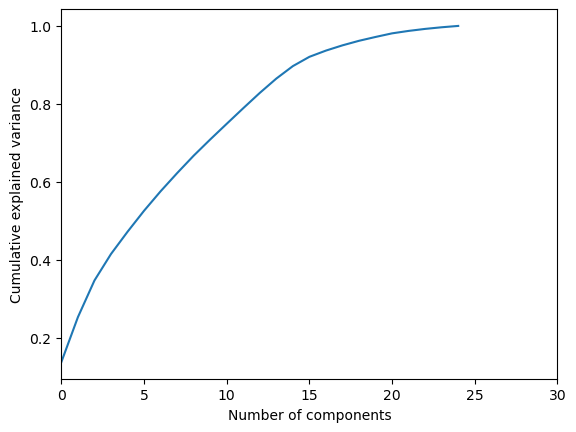

In [18]:
## how many features are needed to explain 90% of the variance?
print("We need " + str(len(PCAcalc_expl_var(x_train=vif_x_train,target_expl_variance=0.9)[0])) + " features (out of " + str(vif_x_train.shape[1]) + " available) to explain 90 percent of the variance after VIF dimensionality reduction")

vif_x_train_scaled = apply_standard_scaler(vif_x_train)[0]
pca = PCA().fit(vif_x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,30,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Dimensionality reduction with PCA

In [16]:
pca_xtrain,pca_xtest,pca_ytrain,pca_ytest = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

In [17]:
xtrain_pca,xtest_pca = PCAcalc_dim_reduction(
    x_train=pca_xtrain,
    x_test=pca_xtest,
    desired_components=len(PCAcalc_expl_var(x_train=pca_xtrain,target_expl_variance=0.9)[0])
)

### Model functions, model selection and first round results

In [14]:
## applicator function for ML methods

def applyMethod_make_regression(x_train,y_train,x_test,y_test,model):
    try:
        model.fit(x_train,y_train)
        ## train error
        y_hat_train = model.predict(x_train)
        train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
        train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
        ## test error
        y_hat_test = model.predict(x_test)
        test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
        test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
        eval_stats = {
            'train_RMSE:':train_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'train_RMSE_to_mean_ratio':train_RMSE / (np.mean(y_train)),
            'train_MAE:':train_MAE,
            'test_RMSE:':test_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'test_RMSE_to_mean_ratio':test_RMSE / (np.mean(y_test)),
            'test_MAE:':test_MAE
        }
        trained_model = model
    except Exception as ex:
        raise ex
    return trained_model,y_hat_test,eval_stats

In [12]:
def ApplyMethod_autoML(x_train,x_test,y_train,y_test,time_budget=int,metric=str,estimator_list=list,task=str):
    auto_ml = AutoML()
    class xgbGamma(XGBoostEstimator):
        def __init__(self, task="regression", **config):
            super().__init__(objective='reg:gamma', **config)
    auto_ml.add_learner(learner_name="xgb_gamma",learner_class=xgbGamma)
    try:
        auto_ml.fit(X_train=x_train,y_train=y_train,time_budget=time_budget,metric=metric,estimator_list=estimator_list,task=task,seed=42,verbose=0)
        ## test error
        y_hat_test = auto_ml.predict(x_test)
        test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
        test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
        ## feature importances
        feature_importances_df = pd.DataFrame({'features':auto_ml.feature_names_in_,'importance':auto_ml.feature_importances_})
        ## train error
        y_hat_train = auto_ml.predict(x_train)
        train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
        train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
        eval_stats = {
            'train_RMSE:':train_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'train_RMSE_to_mean_ratio':train_RMSE / (np.mean(y_train)),
            'train_MAE:':train_MAE,
            'test_RMSE:':test_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'test_RMSE_to_mean_ratio':test_RMSE / (np.mean(y_test)),
            'test_MAE:':test_MAE
        }
        trained_model = auto_ml
    except Exception as ex:
        raise ex
    return trained_model,feature_importances_df,eval_stats

In [31]:
#TODO: #7 fix, finish cross validation function -- DONE
def evalMethod_cross_validate(model,model_params=dict,dataset=pd.DataFrame,target_feature=str,n_splits=int):
## evaluates a model using k-fold cross-validation
    try:
        X = np.array(dataset.drop(columns=str(target_feature)))
        y = np.array(dataset[[str(target_feature)]])
        cv = KFold(n_splits=n_splits,shuffle=True,random_state=42)
        scores = cross_val_score(estimator=model,fit_params=model_params,X=X,y=y,scoring='neg_root_mean_squared_error',cv=cv,n_jobs=-1)
    except Exception as ex:
        raise ex
    return scores

#### PCA versus VIF dimensionality reduction:

The PCA featureset took 4.6 seconds to produce, and needed 2 minutes 14.8 seconds to train a vanilla xgboost regression that produced the following performance statistics:

    {'train_RMSE:': 796.2581,
    'train_RMSE_to_mean_ratio': 0.2789955436479982,
    'train_MAE:': 575.54443,
    'test_RMSE:': 1045.1416,
    'test_RMSE_to_mean_ratio': 0.3666982263503457,
    'test_MAE:': 648.3273}

The VIF featureset took 5 minutes 19.2 seconds to produce, and needed 7.8 seconds to train a vanilla xgboost regression that produced the following performance statistics:

    {'train_RMSE:': 862.523,
    'train_RMSE_to_mean_ratio': 0.302213655111118,
    'train_MAE:': 612.2747,
    'test_RMSE:': 1037.2075,
    'test_RMSE_to_mean_ratio': 0.3639144755129205,
    'test_MAE:': 652.5748}

For comparison, FLAML needed needed 14 minutes, 15.6 seconds to and xgboost regression model on a dataset without any dimensionality reduction. That model produced the following performance statistics:

    {'train_RMSE:': 1262.1234,
    'train_RMSE_to_mean_ratio': 0.4422269612931676,
    'train_MAE:': 624.24036,
    'test_RMSE:': 1005.10626,
    'test_RMSE_to_mean_ratio': 0.3526514331588428,
    'test_MAE:': 623.9275}

(Update with results of cross-validation)

In short, the null hypothesis is true in that dimensionality reduction in this instance does not improve the forecasting accuracy.

In [74]:
pca_regressions = ApplyMethod_autoML(
    x_train=xtrain_pca,
    x_test=xtest_pca,
    y_train=pca_ytrain,
    y_test=pca_ytest,
    time_budget=60,
    metric='mse',
    estimator_list=['rf','extra_tree','lgbm','xgboost'],
    task='regression'
    )
pca_regressions[2]

{'train_RMSE:': 1094.7580574599147,
 'train_RMSE_to_mean_ratio': 0.38358493637162616,
 'train_MAE:': 736.6306754416084,
 'test_RMSE:': 1195.7121863919986,
 'test_RMSE_to_mean_ratio': 0.4195273992729103,
 'test_MAE:': 739.3343840308352}

In [ ]:
## vif xgbregressor
trained_xgbregressor = ApplyMethod_autoML(
    x_train=vif_x_train,
    x_test=vif_x_test,
    y_test=vif_y_test,
    y_train=vif_y_train,
    time_budget=60,
    metric='mse',
    estimator_list=['rf','extra_tree','lgbm','xgboost'],
    task='regression'
    )
trained_xgbregressor[2]

In [18]:
## train-test split with no dimensionality reduction
base_xtrain,base_xtest,base_ytrain,base_ytest = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

In [22]:
auto_xgb_no_reduction = ApplyMethod_autoML(
    x_train=base_xtrain,
    x_test=base_xtest,
    y_train=base_ytrain,
    y_test=base_ytest,
    time_budget=60,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost'],
    task='regression'
)
auto_xgb_no_reduction[2]


check Spark installation...This line should appear only once.

use_spark=True requires installation of PySpark. Please run pip install flaml[spark]
        and check [here](https://spark.apache.org/docs/latest/api/python/getting_started/install.html)
        for more details about installing Spark.


{'train_RMSE:': 1272.384,
 'train_RMSE_to_mean_ratio': 0.4457601473868597,
 'train_MAE:': 625.2692,
 'test_RMSE:': 971.6223,
 'test_RMSE_to_mean_ratio': 0.34065277891073864,
 'test_MAE:': 627.4043}

In [39]:
evalMethod_cross_validate(model=AutoML(),model_params={'time_budget':60,'metric':'mse','task':'regression','estimator_list':['xgboost'],'seed':42},dataset=train_df,target_feature='actual_total_delivery_duration',n_splits=10)

array([-797.08911133, -789.20721436, -786.58618164, -787.4498291 ,
       -786.31195068, -786.04296875, -777.65655518, -786.68359375,
       -792.10949707, -780.45678711])

In [22]:
np.average(np.array([-921.80487061,-1025.06188965,-921.8692627,-880.00769043,-882.80041504,-881.44683838,-1086.76342773,-994.01202393,-924.31524658]))

-946.4535183388889

In [104]:
auto_tree_no_reduction = ApplyMethod_autoML(
    x_train=base_xtrain,
    x_test=base_xtest,
    y_train=base_ytrain,
    y_test=base_ytest,
    time_budget=90,
    metric='mse',
    estimator_list=['rf','extra_tree','lgbm'],
    task='regression'
)
auto_tree_no_reduction[2]

{'train_RMSE:': 1015.4792574138479,
 'train_RMSE_to_mean_ratio': 0.3558069691175209,
 'train_MAE:': 605.8395026020029,
 'test_RMSE:': 1061.6214083499653,
 'test_RMSE_to_mean_ratio': 0.3724803289003977,
 'test_MAE:': 617.9644167109717}

In [136]:
# does the first attempt at modeling improve on a baseline, average-derived model?
createBaseline(historical_data=historical_data)

{'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

### What about a model that predicts order prep/in-store time?

1. Is the amount of time an order spends in the restaurant (prep time) an important feature? 
2. Would the accuracy of a total delivery time model be improved by having an estimation of order preparation time for each order?
3. Assuming the answers to the first two questions are true, is it worth keeping the store and category prepartion stats 'tables' I made during the feature engineering step?

In [43]:
## first and foremost, is this model worth building? Is in-store time an important feature?
hypoth_df = prep_time_df.join(train_df[['actual_total_delivery_duration']])
# hypoth_feature_df = VIF_dim_reduction(feature_frame=hypoth_df,target_feature='actual_total_delivery_duration',vif_limit=20)[0]
hypoth_xtrain,hypoth_xtest,hypoth_ytrain,hypoth_ytest = build_train_test(dataset=hypoth_df,target_feature='actual_total_delivery_duration',test_size=0.2)
hypoth_feature_importances = ApplyMethod_autoML(
    x_train=hypoth_xtrain,
    x_test=hypoth_xtest,
    y_train=hypoth_ytrain,
    y_test=hypoth_ytest,
    time_budget=60,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost'],
    task='regression'
)
hypoth_feature_importances[2]

{'train_RMSE:': 904.6304,
 'train_RMSE_to_mean_ratio': 0.3169233164096178,
 'train_MAE:': 42.500366,
 'test_RMSE:': 349.1138,
 'test_RMSE_to_mean_ratio': 0.12240001528748212,
 'test_MAE:': 41.543285}

In [44]:
hypoth_feature_importances[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
136,est_order_total_prep_time,0.309335
9,estimated_store_to_consumer_driving_duration,0.180432
10,est_time_non-prep,0.169372
14,onshift_to_outstanding,0.148681
13,busy_to_outstanding,0.122805
17,store_est_time_prep_per_item_median,0.014416
8,estimated_order_place_duration,0.012803
25,store_est_median_total_prep_time,0.009709
19,store_est_time_prep_per_item_std,0.007571
16,store_est_time_prep_per_item_max,0.004082


Per the performance scores and feature importance table above, providing a delivery time estimation model with an order prep time estimation greatly improves the quality of estimations. Since the feature est_order_total_prep_time is leaky (it depends on the value we are trying to predict), we will need to estimate it instead.

In [45]:
## produce estimates with mergable indices
## todo: #6 fix appending of new columns -- done

def predict_prep_time(prep_xtrain,prep_xtest,prep_ytrain,prep_ytest,time_budget=int,metric=str,estimator_list=list,prep_est_features_df=pd.DataFrame,delivery_est_features_df=pd.DataFrame) -> pd.DataFrame:
    prep_est_features = prep_est_features_df.drop(columns=['est_order_total_prep_time'])
    prep_time_model = ApplyMethod_autoML(
    x_train=prep_xtrain,
    x_test=prep_xtest,
    y_train=prep_ytrain,
    y_test=prep_ytest,
    time_budget=time_budget,
    metric=metric,
    estimator_list=estimator_list,
    task='regression'
    )
    try:
       yhat = prep_time_model[0].predict(prep_est_features)
       prep_est_features['pred_order_prep_time'] = yhat.reshape(-1,1)
       #osgir = prep_xtrain[['pred_order_prep_time']]
       delivery_est_features = delivery_est_features_df.join(prep_est_features[['pred_order_prep_time']])
       delivery_est_features['est_composite_delivery'] = delivery_est_features['pred_order_prep_time'] + delivery_est_features['est_time_non-prep']
    except Exception as ex:
        raise ex
    return delivery_est_features,prep_time_model[2]

In [62]:
## what if I did not use any dimensionality reduction?
store_prep_split = build_train_test(dataset=prep_time_df,target_feature='est_order_total_prep_time',test_size=0.2)

In [65]:
deliv_est_df = predict_prep_time(
    prep_xtrain=store_prep_split[0],
    prep_xtest=store_prep_split[1],
    prep_ytrain=store_prep_split[2],
    prep_ytest=store_prep_split[3],
    time_budget=120,
    metric='r2',
    estimator_list=['xgb_gamma'],
    prep_est_features_df=prep_time_df,
    delivery_est_features_df=train_df
)
deliv_est_df[1]

{'train_RMSE:': 1170.1553,
 'train_RMSE_to_mean_ratio': 0.5850655668846675,
 'train_MAE:': 589.88654,
 'test_RMSE:': 947.6785,
 'test_RMSE_to_mean_ratio': 0.4741243925561435,
 'test_MAE:': 611.91925}

In [67]:
deliv_xtrain,deliv_xtest,deliv_ytrain,deliv_ytest = build_train_test(dataset=deliv_est_df[0],target_feature='actual_total_delivery_duration',test_size=0.2)

In [72]:
deliv_prep_model = ApplyMethod_autoML(
    x_train=deliv_xtrain,
    x_test=deliv_xtest,
    y_train=deliv_ytrain,
    y_test=deliv_ytest,
    time_budget=120,
    metric='r2',
    estimator_list=['rf','extra_tree','lgbm','xgboost','xgb_gamma'],
    task='regression'
)
deliv_prep_model[2]

{'train_RMSE:': 907.9414091211183,
 'train_RMSE_to_mean_ratio': 0.3180832875822893,
 'train_MAE:': 590.8988058029486,
 'test_RMSE:': 949.8923890480916,
 'test_RMSE_to_mean_ratio': 0.3330342224360306,
 'test_MAE:': 614.9219966432594}

In [73]:
deliv_prep_model[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
137,est_composite_delivery,0.650622
136,pred_order_prep_time,0.313782
14,onshift_to_outstanding,0.014919
10,est_time_non-prep,0.002618
29,clean_store_primary_category__alcohol,0.002037
115,created_hour_of_day__4,0.001956
13,busy_to_outstanding,0.001752
26,store_est_mean_total_prep_time,0.001612
18,store_est_time_prep_per_item_mean,0.001471
6,total_busy_dashers,0.001439


### Results thusfar:

Before I go any farther, it is worth asking if all this modeling is even worth the effort. The function `create_baseline` uses basic averages and outlier removal to provide a delivery duration value for each observation. The performance results for that method are as follows:

    {'baseline_MAE:': 783.5442750429107,
    'baseline_RMSE:': 19249.89784985233}

In short: yes, building models is worth the time, effort and expense for this project. The profession of data science survives.

The most successful model I have built so far requires no dimensionality reduction and and uses an intermediary model to predict the amount of time each order spends in-store. Per the feature importance plot above, the output of that model - `pred_order_prep_time` - is an immensely important feature for estimating total delivery time. To answer question three from the headline above, features from the function `addFeatures_store_prep_stats` make up six of the top fifteen features for the final model, so that featureset should be retained.

The prep time featureset needs 21.6 seconds to train a vanilla xgboost regression model, and when the results of that model are combined with the total delivery time featureset only 7.9 seconds are required to train a vanilla xgboost regression model. That final model produces the following performance statistics:

    {'train_RMSE:': 585.9649,
    'train_MAE:': 437.55215,
    'test_RMSE:': 720.2951,
    'test_MAE:': 516.90875}

(update with cross validation)

Comparison of performance statistics with the best single model approach:

    {'single_model_train_RMSE:': 796.1849 (-26.4034%),
    'single_model_train_MAE:': 561.24567 (-22.0391%),
    'single_model_test_RMSE:': 1014.22095 (-28.9805%),
    'single_model_test_MAE:': 608.876 (-15.1044%)}

For further comparison, the best RMSE from Stratascratch's 'offical solution' for this dataset is 986.6912510458277 using the same holdout/test size. User raihanmasud on GitHub developed a gradient-boosted tree model with calculated paramaters (L1, learning rate, etc.) and achieved a cross-validated RMSE of 1030.6837 from a holdout/test size of 0.33. My model's performance statistics using that sample size are as follows:

    {'train_RMSE:': 634.61224,
    'train_MAE:': 469.97223,
    'test_RMSE:': 1353.4868,
    'test_MAE:': 513.71735}

That significantly outperforms my model, so the next step is to do some parameter tuning and model selection.